# CS x476 - Fall 2021
# Project 1: Image Filtering and Hybrid Images

## Brief
* Due: Friday, 09/17/2021, 11:59PM

* Hand-in: through Gradescope
* Required files:
  * `<your_gt_username>.zip`
  * `<yout_gt_username>.pdf`
  
All projects in this course will be done with these jupyter notebooks. These are convenient ways for you to easily interact with your code. A notebook contains many blocks of code, each of which can be run independently.

There are multiple ways that you can run a cell:
1. Run the current cell, and stay in the current cell
  * `ctrl+enter` on Windows and Linux
  * `cmd+enter` on MacOS
2. Run the current cell, move to the next cell:
  * `shift+enter`
  * click the "Run" button in the tool bar

## Overview
The goal of this assignment is to write an image filtering function and use it to create hybrid images using a simplified version of the SIGGRAPH 2006 [paper](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) by Oliva, Torralba, and Schyns. _Hybrid Images_ are static images that change in interpretation as a function of the viewing distance. The basic idea is that high frequency tends to dominate perception when it is available but, at a distance, only the low frequency (smooth) part of the signal can be seen. By blending the high frequency portion of one image with the low-frequency portion of another, you get a hybrid image that leads to different interpretations at different distances.

This project is intended to build upon the basic PyTorch we did in Project 0, and introduce image filtering. Once you have created an image filtering function, it is relatively straightforward to construct hybrid images. If you don't already know Python, you may find [this resource](https://docs.python.org/3/tutorial/) helpful. If you're unfamiliar with PyTorch, the [tutorials](https://pytorch.org/tutorials/) from the official website are useful.

We provide you with 5 pairs of aligned images which can be merged reasonably well into hybrid images. The alignment is super important because it affects the perceptual grouping (read the paper for details). We encourage you to create additional examples (e.g. change of expression, morph between different objects, change over time, etc.).

For example, we can merge the two images below together:

![Dog](https://dellaert.github.io/19F-4476/images/proj1/dog.jpg)

![Cat](https://dellaert.github.io/19F-4476/images/proj1/cat.jpg)

The low-pass (blurred) and high-pass versions of these images look like this:

![Low Frequencies](https://dellaert.github.io/19F-4476/images/proj1/low_frequencies.jpg)

![High Frequencies](https://dellaert.github.io/19F-4476/images/proj1/high_frequencies.jpg)

The high frequency image is actually zero-mean with negative values, so it is visualized by adding 0.5. In the resulting visualization, bright values are positive and dark values are negative.

As a result of merging these two images, we get this hybrid image:
![Hybrid Image](https://dellaert.github.io/19F-4476/images/proj1/hybrid_image.jpg)

If you're having trouble seeing the multiple interpretations of the image, a useful way to visualize the effect is by progressively downsampling the hybrid image as is done below:

![Cat Hybrid Image Scales](https://dellaert.github.io/19F-4476/images/proj1/cat_hybrid_image_scales.jpg)

We have provided a method `vis_image_scales_numpy()` in `utils.py`, which can be used to save and display such visualizations.

## Important Note:
You will only be working in the following two files:
 - **`student_code.py`**
 - **`cutoff_standarddeviations.txt`**

All the code that you need to add/replace lives in **`student_code.py`**. You will need to replace the cutoff standarddeviations in **`cutoff_standarddeviations.txt`**.

### PLEASE DO NOT MODIFY OTHER FILES

## Setup

In [2]:
import os
import math


import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from typing import List

from proj1_code.utils import load_image, save_image, verify

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [27]:
x = torch.rand(2,3,1)
print(x)
y = (torch.squeeze(x))
print(y)
print(torch.unsqueeze(y,-1))

tensor([[[0.3840],
         [0.0733],
         [0.5440]],

        [[0.8134],
         [0.3848],
         [0.4210]]])
tensor([[0.3840, 0.0733, 0.5440],
        [0.8134, 0.3848, 0.4210]])
tensor([[[0.3840],
         [0.0733],
         [0.5440]],

        [[0.8134],
         [0.3848],
         [0.4210]]])


## Part 1 : 1D filtering

This assignment relies on the concept of filtering signals. A [low pass filter](https://en.wikipedia.org/wiki/Low-pass_filter) removes the high-frequency components of a signal. 

To demonstarte the concepts of filtering in 1-D, we will use simple sine waves. These waves have just one frequency component and hence it will be easy to understand the effects of filtering.

### 1.1 Sinusoids

In this part, we will dive into the concept behind low pass filtering and implement a Gaussian-kernel based low-pass filter.

Let us start with [sinusoids](https://en.wikipedia.org/wiki/Sine_wave) in 1D: sinusoids are a family of sine functions with varying frequency, amplitude, and phase.

$$f(x) = A \text{sin} \left(2 \pi \omega x + \phi \right)$$

where $A$ is the amplitude, $\omega$ is the frequency, and $\phi$ is the phase.

Let us now go through a utility function which will generate sinusoids for us for $x \in [0, 5]$ given the parameters:

In [2]:
fs = 40 # sampling frequency (i.e number of samples of x per second)
x = torch.linspace(0, 5, int(5*fs))

In [3]:
def generate_1d_sinusoid(amplitude: float, frequency: float, phase: float) -> torch.Tensor:
    # Generates sinusoids with given parameters on input x.
    
    return amplitude * torch.sin(2 * math.pi * frequency * x + phase)

In [4]:
def plot_1d_signals(x: torch.Tensor, y_list: List[torch.Tensor], y_labels: List[str]):
    # Plots the 1d signals
    plt.figure()
    
    for (y, label) in zip(y_list, y_labels):
        plt.plot(x, y, label=label)
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    
    plt.show()

Let's generate two sinusoids: one low frequency and one high frequency

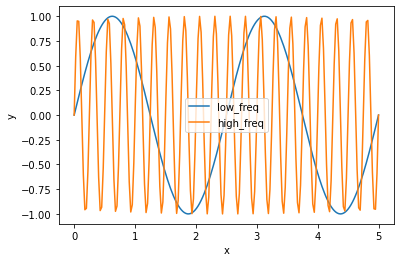

In [5]:
low_freq_sinusoid = generate_1d_sinusoid(1, 0.4, 0)
high_freq_sinusoid = generate_1d_sinusoid(1, 4, 0)
plot_1d_signals(x, [low_freq_sinusoid, high_freq_sinusoid], ['low_freq', 'high_freq'])

We will now linearly combine both the sinusoids to create a new **combined signal**. This signal will serve as an example for low-pass filters where will try to recover the low-frequency sinusoid back.

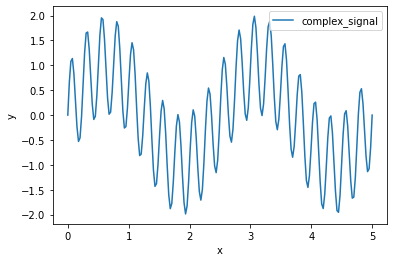

In [6]:
# linear addition of low_freq and high_freq sinusoid
combined_signal = low_freq_sinusoid + high_freq_sinusoid
plot_1d_signals(x, [combined_signal], ['complex_signal'])

We have created a signal with two frequency components. This can be useful to demonstrate low-pass filtering. Recall that low-pass filtering attenuates high-frequency components heavily, whereas the low-frequency components are left unchanged.

We will now design a low pass filter which recovers the low-frequency component from the combined signal.

Averaging operation is a good example of a low-pass filter. In this project, we will use averaging with Gaussian weights as a low-pass filter.

### 1.2 1D Gaussian as Low-Pass filters

A 1D Gaussian filter is of size $k$ is defined as: $$p(x; \mu, \sigma) = \frac{1}{Z} \exp \left( -\frac{\left( x - \mu \right)^2}{2 \sigma^2} \right)$$
where $Z$ is the normalizing coefficient such that the kernel sums to 1 over the range of the input $x \in [0, k)$, $x$ being integers.

The parameters $\mu$ and $\sigma$ are related to $k$ as:
* kernel size $k = 4*\sigma + 1$
* mean $\mu = \lfloor\frac{k}{2}\rfloor$

If we want to use this Gaussian kernel as a low-pass filter with cutoff frequency $\omega_c$ (i.e. allow components with frequency $\omega < \omega_c$ pass through and attenuate components with higher frequency), we need to define the kernel parameters as follows:
* standard deviation $\sigma = \frac{f_s}{2 \pi \omega_c}$.

We can hence use $\sigma$ as the paramterization of the kernel in this project. We can derive $k$ and $\mu$ using $\sigma$.

### **TODO 1**:
implement the function `create_1d_gaussian_kernel` in `student_code.py`

In [7]:
from proj1_code.student_code import create_1d_gaussian_kernel

In [8]:
# helper function to visualize kernel
#x = torch.arange(3)
#print(x)
def plot_kernel(kernel: torch.Tensor):
    '''Plots the kernel'''
    
    plt.figure()
    
    plt.plot(kernel)
    plt.xlabel('idx')
    plt.ylabel('p')
    
    plt.show()

We have two components at frequency 0.4 and 4. Hence lets use 1.5 as the cutoff frequency

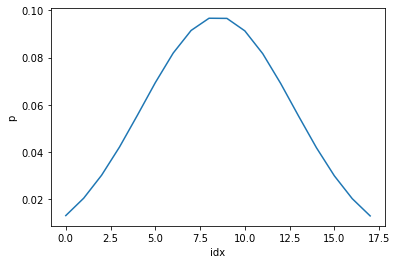

In [9]:
cutoff_frequency = 1.5
standard_deviation = fs/(2*math.pi*cutoff_frequency)
lowpass_1dfilter = create_1d_gaussian_kernel(standard_deviation)
plot_kernel(lowpass_1dfilter)

#kernel = torch.FloatTensor()
#k = 4*standard_deviation+1
#k = math.floor(k)
#variance = (standard_deviation)**2
#k1 = k-1
#mean = (k1*0.5)
#mean = int(mean)
#x = torch.arange(k)
#kernel = torch.exp((-(x-mean)**2)/(2*variance))
#kernel = kernel/torch.sum(kernel)
#print(type(kernel))
#print(kernel)

In [10]:
import proj1_code.proj1_unit_tests.test_create_1d_gaussian_kernel as test_create_1d_gaussian_kernel

print('test_tensor_datatype: ', 
      verify(test_create_1d_gaussian_kernel.test_tensor_datatype))
print('test_create_kernel_with_sigma_int: ', 
      verify(test_create_1d_gaussian_kernel.test_create_kernel_with_sigma_int))
print('test_kernel_sum: ',
      verify(test_create_1d_gaussian_kernel.test_kernel_sum))

test_tensor_datatype:  "Correct"
test_create_kernel_with_sigma_int:  "Correct"
test_kernel_sum:  "Correct"


**Checkpoint**:
* Does the plot look like a Gaussian function?
* Does the unit test(s) pass?

## 1.3 Applying low-pass filter on combined signal (combination of sinusoids with two different frequencies)

We want to use the Gaussian kernel we created to filter out the high frequency sinusoid. For this, you need to implement the function to perform 1D filtering. Let's check that our low-pass filter using Gaussian kernel is working as expected by filtering the low pass and high pass signal separately.

### TODO 2:
implement the function `my_1dfilter` in `student_code.py`

In [11]:
from proj1_code.student_code import my_1d_filter

In [12]:
# applying on low frequency signal
filtered_low_freq_sinusoid = my_1d_filter(low_freq_sinusoid, lowpass_1dfilter)

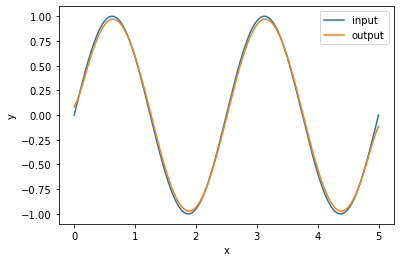

In [13]:
plot_1d_signals(x, [low_freq_sinusoid, filtered_low_freq_sinusoid], ['input', 'output'])

In [14]:
# applying on low frequency signal
filtered_high_freq_sinusoid = my_1d_filter(high_freq_sinusoid, lowpass_1dfilter)

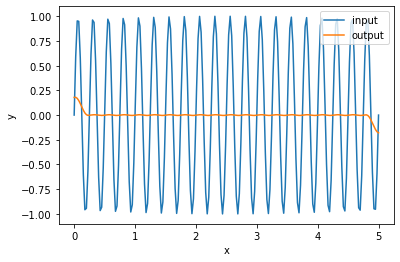

In [15]:
# plot the input
plot_1d_signals(x, [high_freq_sinusoid, filtered_high_freq_sinusoid], ['input', 'output'])

In [16]:
import proj1_code.proj1_unit_tests.test_my_1d_filter as test_my_1d_filter

print('test_filter_with_box_kernel: ', 
      verify(test_my_1d_filter.test_filter_with_box_kernel))
print('test_filter_with_asymmetric_kernel: ', 
      verify(test_my_1d_filter.test_filter_with_asymmetric_kernel))

test_filter_with_box_kernel:  "Correct"
test_filter_with_asymmetric_kernel:  "Correct"


**Checkpoint**:
* Does the filter attenuate the high-frequency signal by a large magnitute, but the low-frequency signal is relatively unaffected
* Does the unit test(s) pass?

In [17]:
# Now, lets observe what happens when we apply this filter to the combined signal
filtered_combined_signal = my_1d_filter(combined_signal, lowpass_1dfilter)

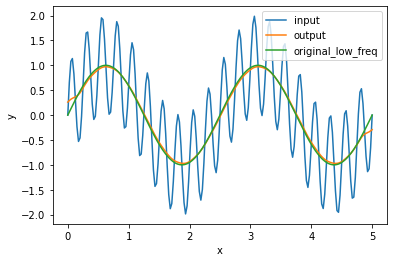

In [18]:
plot_1d_signals(x, [combined_signal, filtered_combined_signal, low_freq_sinusoid], ['input', 'output', 'original_low_freq'])

## Part 2 : Implementing hybrid images in Pytorch manually

**Gaussian Kernels.** Gaussian filters are used for blurring images.

The multivariate Gaussian function is defined as:

$$p(x;\mu, \Sigma) = \frac{1}{(2\pi)^{n/2}\det(\Sigma)^{1/2}}\exp\bigg(-\frac{1}{2}(x-\mu)^\top\Sigma^{-1}(x-\mu)\bigg)$$

where $n$ is equal to the dimension of $x$, $\mu$ is the mean, and $\Sigma$ is the covariance matrix. Similar to 1.2, we will use $\sigma$ as the hyperparameter of the 2D kernel. The kernel shape is $(k,k)$ and the mean is $\mu$ in each dimension. They are related to $\sigma$ as:
- $k = 4*\sigma + 1$
- $\mu= \begin{bmatrix} \lfloor\frac{k}{2}\rfloor \\ \lfloor\frac{k}{2}\rfloor \end{bmatrix}$
- $\Sigma = \begin{bmatrix} \sigma^2 & 0 \\ 0 & \sigma^2 \end{bmatrix}$

Alternatively, you can create a 2D Gaussian by taking the outer product of two vectors. Each such vector should have values populated from evaluating the 1D Gaussian PDF at each coordinate. The 1D Gaussian, as we saw in part 1.2, is defined as:
$$p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi}\sigma} \mbox{exp} \Bigg(-\frac{1}{2\sigma^2}(x-\mu)^2 \Bigg)$$



Note that the sum of values in the 2D kernel should sum to 1.

You will be implementing `create_2D_Gaussian_kernel()` that creates a 2D Gaussian kernel according to a free parameter, _standard deviation_, which controls how much low frequency to leave in the image. This is an important step for later in the project when you create hybrid images!

**Image Filtering.** Image filtering (or convolution) is a fundamental image processing tool. See chapter 3.2 of Szeliski and the lecture materials to learn about image filtering (specifically linear filtering). You will be writing your own function to implement image filtering from scratch. More specifically, you will implement `my_imfilter()` which imitates the `filter2D()` function in the OpenCV library. As specified, your filtering algorithm must: (1) support grayscale and color images, (2) support arbitrarily-shaped filters, as long as both dimensions are odd (e.g. 7x9 filters, but not 4x5 filters), (3) pad the input image with zeros or reflected image content, and (4) return a filtered image which is the same resolution as the input image. We have provided an iPython notebook, `proj1_test_filtering.ipynb`, along with some tests (which are called in `proj1.ipynb`) to help you debug your image filtering algorithm. Note that there is a time limit of 5 minutes for a single call to `my_imfilter()`, so try to optimize your implementation if it goes over.

**Hybrid Images.** A hybrid image is the sum of a low-pass filtered version of one image and a high-pass filtered version of another image. As mentioned in above, _cutoff standarddeviation_ controls how much high frequency to leave in one image and how much low frequency to leave in the other image. In `cutoff_standarddeviation.txt`, we provide a default value of 7 for each pair of images (the value on line _i_ corresponds to the cutoff value for the _i_-th image pair). You should replace these values with the ones you find work best for each image pair. In the paper it is suggested to use two cutoff (one tuned for each image) and you are free to try that as well. You will first implement `create_hybrid_image()` according to the starter code in `student_code.py`. Your function will call `my_imfilter()` using the kernel generated from `create_2d_gaussian_kernel()` to create low and high frequency images and then combine them into a hybrid image.


### Setup

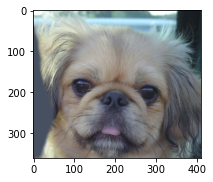

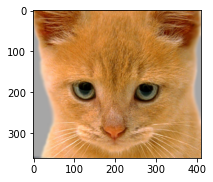

In [19]:
from proj1_code.utils import load_image, save_image

image1 = load_image('data/1a_dog.bmp')
image2 = load_image('data/1b_cat.bmp')

# display the dog and cat images
plt.figure(figsize=(3,3)); plt.imshow((image1*255).byte())
plt.figure(figsize=(3,3)); plt.imshow((image2*255).byte());

### Create filter

### TODO 3:
You will first need to implement `create_2d_gaussian_kernel()` in `student_code.py`.

Success -- kernel values are correct.
True


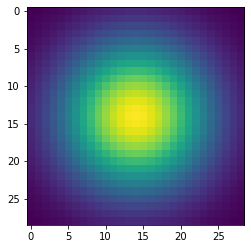

In [20]:
from proj1_code.student_code import create_2d_gaussian_kernel
from proj1_code.proj1_unit_tests.test_2d import verify_gaussian_kernel

cutoff_standard_deviation = 7
kernel = create_2d_gaussian_kernel(cutoff_standard_deviation)

# let's take a look at the filter!
plt.figure(figsize=(4,4)); plt.imshow(kernel);

## Verify that the Gaussian kernel was created correctly
print(verify_gaussian_kernel(kernel, cutoff_standard_deviation))

###### Apply filter to image
### TODO 4:
The next two functions you need to implement in this project can also be found in `student_code.py`. Start by implementing `my_imfilter`, which takes both a filter and an image, and returns the filtered image. This code block will use your `my_imfilter` function to create and display a blurry version of image1.

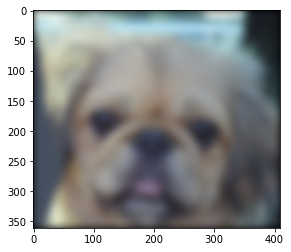

In [21]:
from proj1_code.student_code import my_imfilter

blurry_image = my_imfilter(image1, kernel)
plt.figure(); plt.imshow((blurry_image*255).byte());

### Create hybrid image

### TODO 5:
Next, implement `create_hybrid_image()` in `student_code.py`, which takes two images and makes a hybrid image using the low frequency content from one image and the high frequency content from another by applying the Gaussian kernel you defined in `create_2d_gaussian_kernel()`.

Experiment with the value of `cutoff_standarddeviation` for each pair of images in `data/`. For each image pair, replace `cutoff_standarddeviations.txt` with the best cutoff standard deviation value you find. The value on line *i* of the text file should correspond to _i_-th image pair. This is an important step for the next part! Feel free to also experiment with which image in each pair you grab the low frequencies from and which image you grab high frequencies from.

In [22]:
from proj1_code.student_code import create_hybrid_image
from proj1_code.utils import vis_image_scales_numpy

from proj1_code.proj1_unit_tests.test_2d import (
    verify_low_freq_sq_kernel_torch_manual,
    verify_high_freq_sq_kernel_torch_manual,
    verify_hybrid_image_torch_manual)

low_freq_image, high_freq_image, hybrid_image = create_hybrid_image(image1, image2, kernel)
vis = vis_image_scales_numpy(hybrid_image)
#### Verify that results are as expected
print(verify_low_freq_sq_kernel_torch_manual(image1, kernel, low_freq_image))
print(verify_high_freq_sq_kernel_torch_manual(image2, kernel, high_freq_image))
print(verify_hybrid_image_torch_manual(image1, image2, kernel, hybrid_image))

Success! Low frequency values are correct.
True
Success! High frequency values are correct.
True
Success! Hybrid image values are correct.
True


### Show results

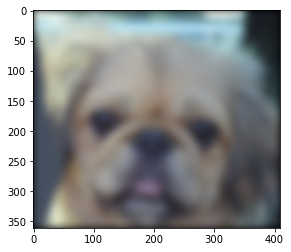

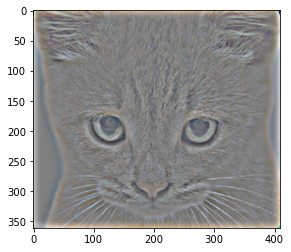

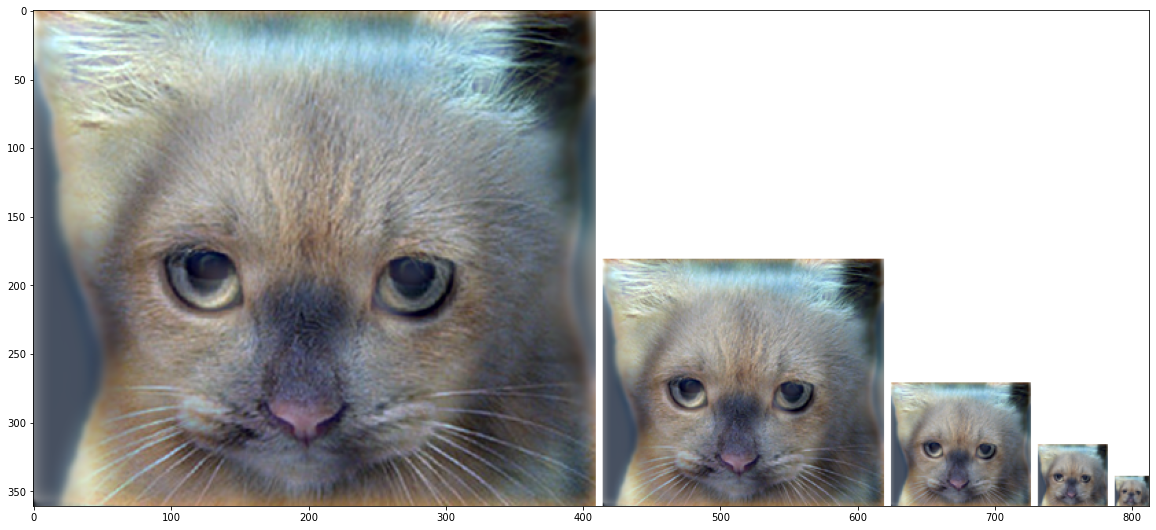

In [23]:
plt.figure(); plt.imshow((low_freq_image * 255).byte());
plt.figure(); plt.imshow(((high_freq_image + 0.5) * 255).byte());
plt.figure(figsize=(20, 20)); plt.imshow(vis);

### Save results

In [24]:
os.makedirs("../results/part2", exist_ok=True)
save_image('../results/part2/low_freq_image.jpg', low_freq_image)
save_image('../results/part2/high_freq_image.jpg', high_freq_image + 0.5)
save_image('../results/part2/hybrid_image.jpg', hybrid_image)
save_image('../results/part2/hybrid_image_scales.jpg', vis)

## Part 3: Using PyTorch's inbuilt operators

### TODO 6:
**Dataloader:** You will now implement creating hybrid images again but using PyTorch. The `HybridImageDataset` class in `student_code.py` will create tuples using pairs of images with a corresponding cutoff standard deviation (which you should have found from experimenting in Part 2). The images will be loaded from `data/` and the cutoff standard deviation from `cutoff_standarddeviations.txt`. Refer to [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for additional information on data loading & processing.

### TODO 7:
**Model:** Next, you will implement the `HybridImageModel` class in `student_code.py`. Instead of using your implementation of `my_imfilter()` to get the low and high frequencies from a pair of images, `low_pass()` should use the 2d convolution operator from `torch.nn.functional` to apply a low pass filter to a given image. You will have to implement `get_kernel()` which calls your `create_2d_gaussian_kernel()` function for each pair of images using the cutoffs as specified in `cutoff_standarddeviations.txt` and reshapes it to the appropriate dimensions for PyTorch. Then, similar to `create_hybrid_image()` from Part 2, `forward()` will call `get_kernel()` and `low_pass()` to create the low and high frequency images and combine them into a hybrid image. Refer to [this tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) for additional information on defining neural networks using PyTorch.

Lastly, you will compare the runtimes of your hybrid image implementations from Parts 2 and 3.

Make sure you have specified a cutoff value in `cutoff_standarddeviations.txt` for each image pair in `data/` before executing the following blocks.

In [25]:
import torch
import torchvision

from proj1_code.student_code import HybridImageDataset
from proj1_code.student_code import HybridImageModel


data_root = 'data' # if you're using additional data, make sure to change this to '../additional_data'
cf_file = 'cutoff_standarddeviations.txt'

### Instantiate model & dataset
Implement `HybridImageModel` and `HybridImageDataset` in `student_code.py`.

In the code documentation, you will see a term called "batch size", which we will discuss in later projects and lectures. For now, we are using the default value of 1. 

In [26]:
model = HybridImageModel()
dataset = HybridImageDataset(data_root, cf_file)
dataloader = torch.utils.data.DataLoader(dataset)

### Create hybrid images
This code block will iterate through pairs of images from your dataset and create a hybrid image using the low frequency content from one image and the high frequency content from another.

In [27]:
for i, sample in enumerate(dataloader):
    image_a, image_b, cutoff_standarddeviation = sample
    low_frequencies, high_frequencies, hybrid_image = model(image_a, image_b, cutoff_standarddeviation)
    
    os.makedirs("../results/part3", exist_ok=True)
    # saves low frequencies, high frequencies, and hybrid image of each pair of images
    torchvision.utils.save_image(low_frequencies, '../results/part3/%d_low_frequencies.jpg' % i)
    torchvision.utils.save_image(high_frequencies+0.5, '../results/part3/%d_high_frequencies.jpg' % i)
    torchvision.utils.save_image(hybrid_image, '../results/part3/%d_hybrid_image.jpg' % i)

In [28]:
## Verify that the results are correct, with cutoff_frequency of 7
from proj1_code.proj1_unit_tests.test_2d import (
    verify_low_freq_sq_kernel_pytorch, 
    verify_high_freq_sq_kernel_pytorch,
    verify_hybrid_image_pytorch
)

dataset = HybridImageDataset(data_root, cf_file)
dataloader = torch.utils.data.DataLoader(dataset)
image_a, image_b, cutoff = next(iter(dataloader))
low_frequencies, high_frequencies, hybrid_image = model(image_a, image_b, cutoff)

cutoff_sd = torch.Tensor([7])
## On first dog/cat pair, verify that the Pytorch results are as expected
print(verify_low_freq_sq_kernel_pytorch(image_a, model, cutoff_sd, low_frequencies))
print(verify_high_freq_sq_kernel_pytorch(image_b, model, cutoff_sd, high_frequencies))
## Verify that the Pytorch hybrid images are created correctly
print(verify_hybrid_image_pytorch(image_a, image_b, model, cutoff_sd, hybrid_image))

Success! PyTorch low frequency values are correct.
True
Success! PyTorch high frequency values are correct.
True
Success! PyTorch hybrid image values are correct.
True


### Hybrid image timing comparison
Here, we will compare the runtime of creating hybrid images using your manual Torch implementation to the PyTorch implementation.

In [29]:
import time

image1 = load_image('data/1a_dog.bmp')
image2 = load_image('data/1b_cat.bmp')

Timing Part 2. Notice that we explicitly include `create_2D_Gaussian_kernel()` in the timing of Part 2 but not Part 3. This is because the function is already being called (and therefore timed) inside the forward pass of `HybridImageModel`.

In [30]:
start = time.time()
cutoff_standarddeviation = 7
kernel = create_2d_gaussian_kernel(cutoff_standarddeviation)
low_frequencies, high_frequencies, hybrid_image = create_hybrid_image(image1, image2, kernel)
end = time.time() - start
print('Part 1: {:.3f} seconds'.format(end))

Part 1: 30.608 seconds


Timing Part 3

In [31]:
model = HybridImageModel()

start = time.time()
low_frequencies, high_frequencies, hybrid_image = model(image_a, image_b, torch.Tensor([cutoff_standarddeviation]))
end = time.time() - start
print('Part 2: {:.3f} seconds'.format(end))

Part 2: 1.521 seconds


### Median Filtering

In this section, we will implement a median filter and apply it on an image (grayscale only). A median filter is a non-linear filter that is used for noise reduction in images / other signals. For a window of size $(N, N)$, a median filter replaces the center pixel of the neighborhood with the median value of all the pixels in the window. An example of a 2D median filter is given below:

![median_filter](./data/median_filter.jpeg "Median Filter")

In the above example, a kernel of size $3 \times 3$ is applied over a region of the image and the center pixel is being replaced by the value $9$, which is the median of all the pixel values in this region. 

### TODO 8:

Implement the `my_median_filter` function in `student_code.py` file based on the given below information:
- The input image will always be a grayscale image of dimensions $(m, n, 1)$ or $(m, n)$.
- The filter size will always be odd and it can either be a scalar value or a tuple of integers
- The output must be a tensor of dimensions $(m, n, 1)$. To ensure that the spatial resolution remains the same, you need to use zero-padding.

Let us load the image 

(450, 450)


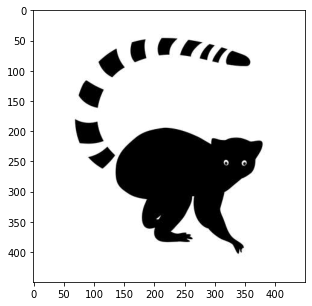

In [32]:
median_img = Image.open('data/median_filter_test.jpeg').convert('L')
plt.figure(figsize=(5,5)); plt.imshow((np.array(median_img)), cmap='gray')
print(median_img.size)
#print(len(median_img.size))

#### Applying median filter 
Here, we will apply the median filter on the above given image. Test several different values for filter size and observe the differences in the output. 
1. What happens to the corners of the images when the filter size is very large? Is there a simple explanation for the same?
2. Think of a few methods to avoid the above issue (if any). Are there an disadvantages of using these methods over simple zero padding of the input image?
3. Apply the median filter on the coin.png image given in the data folder. Is the median filter able to remove the noise to a certain extent? Can we use a Gaussian filter instead of the median filter for the same purpose?

Final Image Size: (450, 450)


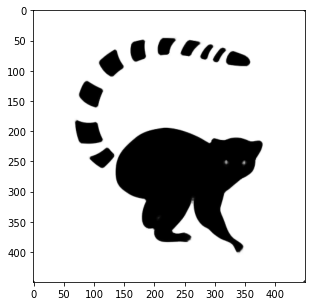

In [33]:
from student_code import my_median_filter
median_img_torch = torch.tensor(np.array(median_img), dtype=torch.float)
# Code output
my_output = my_median_filter(median_img_torch, (7,7))
my_output = my_output.squeeze(2).numpy()
plt.figure(figsize=(5,5)); plt.imshow((np.array(my_output)), cmap='gray')
print('Final Image Size:',my_output.shape)

# *Extra Credit

## _This part is optional for undergraduate students (4476), but required for graduate students (6476)_

In this section, we will learn about formulating the Discrete Fourier Transform matrix, and use it to run DFT for 2D images, and implement a low-pass filter based on your DFT analysis results. 

### DFT for 2D signal

An N-point DFT is expressed as the multiplication $X=Wx$, where $x$ is the original input signal, $W$ is the N-by-N square DFT matrix, and $X$ is the DFT of the signal. The [wiki](https://en.wikipedia.org/wiki/DFT_matrix) provides a good introduction on DFT matrix for a 1D signal. The DFT equation for a 2D square matrix is:
$$U_{mn}=\frac{1}{M}e^{-j\frac{2\pi mn}{M}}$$
where $M=N$. 

### TODO 8:
Implement the `dft_matrix` in `student_code.py` function based on the given information.

In this part, we begin with a simple situation where we assume all the 2D image matrices are square, grayscale matrices, which would make your life easier.

In [34]:
from proj1_unit_tests.test_dft import test_dft_matrix

print(test_dft_matrix())

Success! The DFT matrix for dimension 4 is correct!
True


### Image filtering based on Discrete Fourier Transform (DFT)

A brief review on the DFT for 2D images:
$$F[k,l]=\sum_{m=0}^{M-1}\sum_{n=0}^{N-1}f[m,n]exp(-j\frac{2\pi}{M}km-j\frac{2\pi}{N}ln)$$
where $$0\leq k \leq M-1$$ $$0\leq l \leq N-1$$

We observe that the DFT transform of each row is independent from that of the column. This means in order to obtain the 2D DFT transform, we can run a 1D DFT of then columns, then a 1D DFT of rows consecutively (or rows first, then columns). That would save us a lot of computation!

### TODO 9:
We can now use the `dft_matrix` function in `student_code.py` to generate DFT for a normal image, and implement the function `my_dft`.

In [35]:
from proj1_unit_tests.test_dft import test_dft

print(test_dft())

Success! The DFT matrix for A is correct!
True


### Generate low-pass filter!

### TODO 10:
Finally, we implement a low-pass filter based on your own DFT, and add the results of the following images to your report. :`data_part4/6a_dog.bmp`, `data_part4/6b_cat.bmp`; the resolution is 512x512.

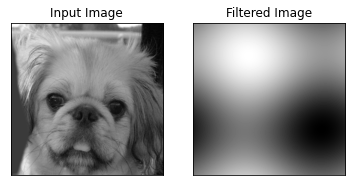

In [36]:
from PIL import Image, ImageOps
from proj1_code.student_code import dft_filter
import torchvision.transforms as transforms

image6 = Image.open('data_part4/6a_dog.bmp')
image_gray = transforms.ToTensor()(image6)[0,:,:]
img_dft_filter = dft_filter(image_gray)

plt.subplot(121), plt.imshow(image_gray, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_dft_filter, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()

# *Extra Credit (for ALL)
### Impressive Hybrid Images

It is also possible to get extra credit for this project as well if you come up with some clever hybrid images which impress the TAs and Frank. Additionally, you should add slides at the end of your report further showing your results. The best ones get a special mention from Frank at the beginning of one of the future lectures!

# Forbidden functions

You can use these for testing, but not in your final code: anything that takes care of the filtering operation or creates a 2D Gaussian kernel directly for you. ex. (cv2.getGaussianKernel) If it feels like you're sidestepping the work, then it's probably not allowed. Ask the TAs if you have any doubts.

# Code Testing

We have provided a set of tests for you to evaluate your implementation. We have included tests inside `proj1.ipynb` so you can check your progress as you implement each section. When you're done with the entire project, you can call additional tests by running `pytest proj1_unit_tests` inside the `proj1_code` directory of the project. _Your grade on the coding portion of the project will be further evaluated with a set of tests not provided to you._

# Writeup

For this project (and all other projects), you must do a project report using the template slides provided to you at "proj1_template.pptx". Do <u>not</u> change the order of the slides or remove any slides, as this will affect the grading process on Gradescope and you will be deducted points. In the report you will describe your algorithm and any decisions you made to write your algorithm a particular way. Then you will show and discuss the results of your algorithm. The template slides provide guidance for what you should include in your report. A good writeup doesn't just show results--it tries to draw some conclusions from the experiments. You must convert the slide deck into a PDF with the name `<your_gt_username.pdf>` for your submission.

If you choose to do anything extra, add slides _after the slides given in the template deck_ to describe your implementation, results, and analysis. Adding slides in between the report template will cause issues with Gradescope, and you will be deducted points. You will not receive full credit for your extra credit implementations if they are not described adequately in your writeup. 

# Please check your assignment completion

### Required for all
* `create_1d_gaussian_kernel()`
* `my_1d_filter()`
* `create_2d_gaussian_kernel()`
* `my_imfilter()`
* `create_hybrid_image()`
* `make_dataset()`
* `get_cutoff_standarddeviations()`
* `HybridImageDataset#__init__()`
* `HybridImageDataset#__len__()`
* `HybridImageDataset#__getitem__()`
* `HybridImageModel#get_kernel()`
* `HybridImageModel#low_pass()`
* `HybridImageModel#forward()`
* `my_median_filter()`

### Report
* Answer all the questions on the report correctly

### Required for 6476 students, Optional for 4476 students
* `dft_matrix()`
* `my_dft()`
* `dft_filter()` results in the report


### Note
* Additional hybrid images will be awarded extra credits, graded on creativity and originality
* Lose 5 points for every time you do not follow the instructions for the hand-in format.


# Submission

This is very important as you will lose 5 points for every time you do not follow the instructions. 

Do <u>not</u> install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that's not in there by default will probably cause your code to break during grading. Do <u>not</u> use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. Create the zip file using `python zip_submission.py --gt_username <your_gt_username>` (it will zip up the appropriate directories/files for you!) and hand it through Gradescope. Remember to submit your report as a PDF to Gradescope as well.

# Credit
- Assignment developed by Arvind Krishnakumar, Ayush Baid, Sen Wang and Frank Dellaert, based on a similar project by James Hays, Derek Hoiem, Cusuh Ham, John Lambert and Samarth Brahmbhatt.<br/>
- Assignment modified and re-structured by Junyan Mao, Shashank Srikanth in Fall 2021.